In [388]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import matplotlib.pyplot as plt
import pytorch_lightning as pl
torch.manual_seed(0)

In [404]:
from einops.layers.torch import Reduce

In [6]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataset, val_dataset = random_split(training_data, [55000, 5000])

learning_rate = 1e-3
batch_size = 128
epochs = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [704]:
import numpy as np

In [7]:
data, label = next(iter(train_dataloader))

In [8]:
data.shape #[batch_size, channel, width, height]

torch.Size([128, 1, 28, 28])

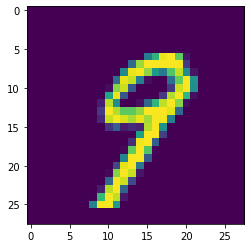

In [12]:
plt.imshow(data[0].reshape(28,28))

In [327]:
label

tensor([9, 2, 1, 2, 2, 5, 6, 0, 6, 3, 8, 2, 7, 8, 5, 5, 9, 8, 0, 9, 2, 2, 4, 7,
        9, 8, 8, 8, 5, 6, 3, 3, 0, 0, 8, 3, 0, 8, 0, 8, 6, 3, 5, 9, 4, 6, 8, 8,
        6, 6, 1, 0, 8, 1, 9, 9, 9, 4, 6, 8, 5, 7, 8, 1, 4, 0, 9, 5, 7, 0, 7, 0,
        4, 8, 5, 5, 4, 7, 5, 5, 6, 0, 1, 0, 1, 0, 2, 6, 6, 2, 9, 3, 7, 4, 8, 3,
        6, 8, 7, 5, 9, 9, 9, 2, 9, 3, 7, 7, 5, 1, 7, 7, 2, 7, 7, 9, 5, 1, 2, 1,
        5, 8, 5, 1, 1, 9, 7, 3])

In [769]:
data[0].shape

torch.Size([1, 28, 28])

In [772]:
project = nn.Conv2d(1, 16, kernel_size= 4, stride=4)
#in_chan = 1
#self.emb_size = Channel * Patch Size * Patch Size = 1 * 4 * 4 = 16
#Kernel Size = Patch Size 
#Stride = Patch Size
project(data[0].unsqueeze(0)).shape

torch.Size([1, 16, 7, 7])

In [432]:
class EmbeddingLayer(nn.Module):
    def __init__(self,in_chan, img_size, patch_size,batch_size=128):
        super().__init__()
        self.num_patches = int(img_size / pow(patch_size, 2)) # 49
        self.emb_size = in_chan * patch_size * patch_size # 16
        self.project = nn.Conv2d(in_chan, self.emb_size, kernel_size= patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,self.emb_size))
        self.positions = nn.Parameter(torch.randn(self.num_patches+ 1, self.emb_size)) # [50,16]
    
 
    def forward(self, x):
        x = self.project(x)
        x = x.view(-1, 49, 16) # [batch_size, 49, 16]
        repeat_cls = self.cls_token.repeat(x.size()[0],1,1) #[batch_size, 1 , 16]
        x = torch.cat((repeat_cls, x), dim=1)
        x += self.positions
        return x

In [520]:
class Multihead(nn.Module):
    def __init__(self, emb_size, num_heads):
        super().__init__()
        self.multiheadattention = nn.MultiheadAttention(emb_size, num_heads, batch_first = True, dropout=0.2)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attn_output, attention = self.multiheadattention(query, key, value)
        return attn_output, attention


In [521]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.2):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )

In [522]:
class VIT(nn.Module):
    def __init__(self,emb_size = 16):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(1, 28*28, 4)
        self.Multihead = Multihead(emb_size, 8)
        self.FFB = FeedForwardBlock(emb_size)
        self.norm = nn.LayerNorm(emb_size)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        
        norm_x = self.norm(x)
        multihead_output, attention = self.Multihead(norm_x)
        
        #residual Function
        output = multihead_output + x
        
        norm_output = self.norm(output)
        FFB = self.FFB(norm_output)
        
        final_out = FFB + output
        
        return final_out, attention
        
        

        
        

In [730]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_layers: 5, ):
        super().__init__()
        self.layers = nn.ModuleList([VIT() for _ in range(n_layers)])
        
    def forward(self, x):
        for layer in self.layers:
            final_out, attention = layer(x)
            
        return final_out

In [731]:
import torchmetrics
ac = torchmetrics.Accuracy(task="multiclass", num_classes = 10).to('cuda')

In [789]:
class VIT_Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.loss = []
        self.Encoder = nn.Sequential(
            TransformerEncoder(n_layers = 5),
            #Reduce('b n e -> b e', reduction='mean')
        )
        self.final_layer = nn.Linear(16, 10)
        self.val_loss = []
        self.acc = []
        self.test_acc =[]
        
    def forward(self, x):
        x = self.Encoder(x)
        cls_token_final = x[:,0]
        #(cls_token_final.shape)
        cls_token_final = self.final_layer(cls_token_final)
        return cls_token_final
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)

        self.loss.append(loss.item())
        return loss 
    
    def training_epoch_end(self, batch):
        mean_loss = sum(self.loss) / 430
        print(f'traing_loss :{mean_loss}')
        self.loss = []
        self.acc = []
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)
        self.val_loss.append(loss.item())
        acc = ac(logits, y)
        self.acc.append(acc)
        return loss 
    
    def validation_epoch_end(self, batch):
        mean_loss = sum(self.val_loss) / 40
        mean_acc = sum(self.acc)/ 40
        print(f'val loss :{mean_loss}, val_acc : {mean_acc}')

        self.val_loss = []
        self.acc = []
        self.log("val_loss", mean_loss)
        
    def test_dataloader(self):
        return test_dataloader
        
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = ac(logits, y)
        self.test_acc.append(acc)
        
    def test_epoch_end(self, batch):
        mean_acc = sum(self.test_acc)/ 79
        print(mean_acc)


            
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)              
        

In [774]:
gpus = torch.cuda.device_count()
gpus

1

In [792]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_loss', mode ='min', patience=5)

In [762]:
k = model.test_dataloader()
b, y = next(iter(k))
print(y.shape)

torch.Size([128])


In [793]:
model = VIT_Encoder()
trainer = pl.Trainer(max_epochs=50, gpus=gpus, callbacks=[early_stop_callback])
trainer.fit(model, train_dataloader, val_dataloaders = val_dataloader)


/home/daewoong/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | Encoder     | Sequential | 25.8 K
1 | final_layer | Linear     | 170   
-------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val loss :0.12517818212509155, val_acc : 0.004101562779396772


/home/daewoong/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/daewoong/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val loss :0.5484731838107109, val_acc : 0.8345703482627869
traing_loss :1.3649210821750553


Validation: 0it [00:00, ?it/s]

val loss :0.3908920146524906, val_acc : 0.887890636920929
traing_loss :0.6004866651324339


Validation: 0it [00:00, ?it/s]

val loss :0.3312680784612894, val_acc : 0.900195300579071
traing_loss :0.4832906384800756


Validation: 0it [00:00, ?it/s]

val loss :0.29909618236124513, val_acc : 0.907031238079071
traing_loss :0.43166882517032845


Validation: 0it [00:00, ?it/s]

val loss :0.27738097179681065, val_acc : 0.912304699420929
traing_loss :0.39516571992358496


Validation: 0it [00:00, ?it/s]

val loss :0.2638250712305307, val_acc : 0.916015625
traing_loss :0.37600332131219466


Validation: 0it [00:00, ?it/s]

val loss :0.24782598074525594, val_acc : 0.9189453125
traing_loss :0.35403133679267973


Validation: 0it [00:00, ?it/s]

val loss :0.24526625629514456, val_acc : 0.9222656488418579
traing_loss :0.34141708310953406


Validation: 0it [00:00, ?it/s]

val loss :0.2307335190474987, val_acc : 0.9267578125
traing_loss :0.3297123735727266


Validation: 0it [00:00, ?it/s]

val loss :0.22334411069750787, val_acc : 0.9273437857627869
traing_loss :0.32203059227660646


Validation: 0it [00:00, ?it/s]

val loss :0.2161060587503016, val_acc : 0.9292969107627869
traing_loss :0.30902462165023004


Validation: 0it [00:00, ?it/s]

val loss :0.21074438672512769, val_acc : 0.9310547113418579
traing_loss :0.29872354106154553


Validation: 0it [00:00, ?it/s]

val loss :0.20726080713793635, val_acc : 0.932812511920929
traing_loss :0.2949438666708248


Validation: 0it [00:00, ?it/s]

val loss :0.20285544786602258, val_acc : 0.93359375
traing_loss :0.2882994276146556


Validation: 0it [00:00, ?it/s]

val loss :0.20297506358474493, val_acc : 0.9326171875
traing_loss :0.28289450715447584


Validation: 0it [00:00, ?it/s]

val loss :0.194326833402738, val_acc : 0.937304675579071
traing_loss :0.277126031576894


Validation: 0it [00:00, ?it/s]

val loss :0.19564820323139429, val_acc : 0.9361328482627869
traing_loss :0.2728434950806374


Validation: 0it [00:00, ?it/s]

val loss :0.19008799996227027, val_acc : 0.9365234375
traing_loss :0.26526773015773575


Validation: 0it [00:00, ?it/s]

val loss :0.18922426765784622, val_acc : 0.938281238079071
traing_loss :0.2657002580373786


Validation: 0it [00:00, ?it/s]

val loss :0.18735023215413094, val_acc : 0.9398437738418579
traing_loss :0.260974653983532


Validation: 0it [00:00, ?it/s]

val loss :0.183638986479491, val_acc : 0.9378906488418579
traing_loss :0.25849229991436007


Validation: 0it [00:00, ?it/s]

val loss :0.18294915785081683, val_acc : 0.939648449420929
traing_loss :0.2570756321902885


Validation: 0it [00:00, ?it/s]

val loss :0.1807734384201467, val_acc : 0.9404296875
traing_loss :0.2501537523124107


Validation: 0it [00:00, ?it/s]

val loss :0.1781563595868647, val_acc : 0.9429687857627869
traing_loss :0.24940759406186813


Validation: 0it [00:00, ?it/s]

val loss :0.18209007922559978, val_acc : 0.939453125
traing_loss :0.2477283178027286


Validation: 0it [00:00, ?it/s]

val loss :0.17813522443175317, val_acc : 0.939257800579071
traing_loss :0.24635714673718742


Validation: 0it [00:00, ?it/s]

val loss :0.1762422887608409, val_acc : 0.943164050579071
traing_loss :0.2430903580472913


Validation: 0it [00:00, ?it/s]

val loss :0.17275495305657387, val_acc : 0.942578136920929
traing_loss :0.23963141916103142


Validation: 0it [00:00, ?it/s]

val loss :0.16931203505955636, val_acc : 0.944140613079071
traing_loss :0.23924667275575703


Validation: 0it [00:00, ?it/s]

val loss :0.17093060472980143, val_acc : 0.9427734613418579
traing_loss :0.23323773090229477


Validation: 0it [00:00, ?it/s]

val loss :0.17236913028173148, val_acc : 0.9443359375
traing_loss :0.231015179739442


Validation: 0it [00:00, ?it/s]

val loss :0.1662702165544033, val_acc : 0.9449219107627869
traing_loss :0.22996924992564113


Validation: 0it [00:00, ?it/s]

val loss :0.1612310552969575, val_acc : 0.947070300579071
traing_loss :0.22961596534695736


Validation: 0it [00:00, ?it/s]

val loss :0.16333055566065013, val_acc : 0.947265625
traing_loss :0.2269822043388389


Validation: 0it [00:00, ?it/s]

val loss :0.1599510909989476, val_acc : 0.947265625
traing_loss :0.2254249397232089


Validation: 0it [00:00, ?it/s]

val loss :0.16176120219752194, val_acc : 0.9462890625
traing_loss :0.22380028200703997


Validation: 0it [00:00, ?it/s]

val loss :0.16431734208017587, val_acc : 0.9466797113418579
traing_loss :0.22366772763604342


Validation: 0it [00:00, ?it/s]

val loss :0.16318094190210103, val_acc : 0.947265625
traing_loss :0.2222879458478717


Validation: 0it [00:00, ?it/s]

val loss :0.15919503346085548, val_acc : 0.947460949420929
traing_loss :0.21853907825641855


Validation: 0it [00:00, ?it/s]

val loss :0.15789303286001086, val_acc : 0.948046863079071
traing_loss :0.21818865499524184


Validation: 0it [00:00, ?it/s]

val loss :0.1536653134971857, val_acc : 0.949414074420929
traing_loss :0.21941776005334632


Validation: 0it [00:00, ?it/s]

val loss :0.15726392194628716, val_acc : 0.950390636920929
traing_loss :0.2112736363397088


Validation: 0it [00:00, ?it/s]

val loss :0.1553529491648078, val_acc : 0.9501953125
traing_loss :0.21191093332545702


Validation: 0it [00:00, ?it/s]

val loss :0.15155737195163965, val_acc : 0.952343761920929
traing_loss :0.21275924901629603


Validation: 0it [00:00, ?it/s]

val loss :0.15079029505141078, val_acc : 0.953125
traing_loss :0.20928015438623207


Validation: 0it [00:00, ?it/s]

val loss :0.1539731166791171, val_acc : 0.951171875
traing_loss :0.21012699643886368


Validation: 0it [00:00, ?it/s]

val loss :0.15566402478143573, val_acc : 0.9488281607627869
traing_loss :0.20589194604477218


Validation: 0it [00:00, ?it/s]

val loss :0.15390957314521075, val_acc : 0.9505859613418579
traing_loss :0.20485640565843083


Validation: 0it [00:00, ?it/s]

val loss :0.15852739019319415, val_acc : 0.947460949420929
traing_loss :0.20252573124544565


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


val loss :0.15436716694384814, val_acc : 0.9505859613418579
traing_loss :0.2040096810564052


In [794]:
trainer.test()

/home/daewoong/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/daewoong/userdata/Study/lightning_logs/version_48/checkpoints/epoch=49-step=21500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/daewoong/userdata/Study/lightning_logs/version_48/checkpoints/epoch=49-step=21500.ckpt
/home/daewoong/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worke

Testing: 0it [00:00, ?it/s]

tensor(0.9510, device='cuda:0')


[{}]